In [2]:
pip install keras

     |████████████████████████████████| 1.3 MB 2.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

     |████████████████████████████████| 207.1 MB 4.1 MB/s eta 0:00:01    |█████████████▋                  | 88.2 MB 4.0 MB/s eta 0:00:30     |████████████████████████████▌   | 184.2 MB 4.3 MB/s eta 0:00:06
     |████████████████████████████████| 1.0 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 4.0 MB/s eta 0:00:01    |████                            | 1.6 MB 3.3 MB/s eta 0:00:04
     |████████████████████████████████| 4.0 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 4.1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np

In [2]:
nima=pd.DataFrame(np.array([1,2,0,4,0,6,7,0,9,0]), columns=['A'])
nima['A']=nima['A'].replace(0,nima['A'].mean())
nima


,A
0,1.0
1,2.0
2,2.9
3,4.0
4,2.9
5,6.0
6,7.0
7,2.9
8,9.0
9,2.9


In [980]:
df = pd.read_csv('OEP_refined_test_2.csv')
df = df.drop(columns = ['Unnamed: 0'])
df.Date = pd.to_datetime(df.Date)
df['Date'] +=  pd.to_timedelta(df.Hour, unit='h')
df.drop(df.loc[df['Date'].duplicated()].index, inplace=True)
df = df.set_index(df.Date).drop(columns = ['Date'])
df.drop(columns='Hour', inplace=True)
for v in df['¢/kWh']:
    if v<1:
        df['¢/kWh']= df['¢/kWh'].replace(v,df['¢/kWh'].median()/1.2)

In [981]:
df['¢/kWh'].median()/1.2

10.791666666666666

In [982]:
df

,¢/kWh,Temperature,Humidity
Date,,,
2016-01-01 00:00:00,10.791667,-0.3,70
2016-01-01 01:00:00,10.791667,-0.3,68
2016-01-01 02:00:00,10.791667,-0.4,73
2016-01-01 12:00:00,10.791667,-2.1,76
2016-01-01 13:00:00,10.791667,-2.4,84
...,...,...,...
2020-12-31 19:00:00,36.850000,0.2,74
2020-12-31 20:00:00,19.690000,-0.2,65
2020-12-31 21:00:00,20.780000,-3.0,80


In [983]:
df[df['¢/kWh']<1].sum()

¢/kWh          0.0
Temperature    0.0
Humidity       0.0
dtype: float64

In [95]:
#df['2016-01-01 00:00:00':'2016-12-31 23:00:00']=df['2016-01-01 00:00:00':'2016-12-31 23:00:00'].replace(0.00,method='bfill')
#df['2017-01-01 00:00:00':'2017-12-31 23:00:00']=df['2017-01-01 00:00:00':'2017-12-31 23:00:00'].replace(0.00,df['2017-01-01 00:00:00':'2017-12-31 23:00:00'].mean())
##df['2018-01-01 00:00:00':'2018-12-31 23:00:00']=df['2018-01-01 00:00:00':'2018-12-31 23:00:00'].replace(0.00,df['2018-01-01 00:00:00':'2018-12-31 23:00:00'].mean())
#df['2019-01-01 00:00:00':'2019-12-31 23:00:00']=df['2019-01-01 00:00:00':'2019-12-31 23:00:00'].replace(0.00,df['2019-01-01 00:00:00':'2019-12-31 23:00:00'].mean())
##df['2020-01-01 00:00:00':'2020-12-31 23:00:00']=df['2020-01-01 00:00:00':'2020-12-31 23:00:00'].replace(0.00,df['2020-01-01 00:00:00':'2020-12-31 23:00:00'].mean())

In [984]:
def table2lags(table, max_lag, min_lag=0, separator='_'):
    """ Given a dataframe, return a dataframe with different lags of all its columns """
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(table.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in table.columns]
    return pd.concat(values, axis=1)

In [985]:
df_lagged = table2lags(df, 168, 24)
df_lagged.shape

(39405, 435)

In [973]:
df_lagged.columns

Index(['¢/kWh_24', 'Temperature_24', 'Humidity_24', '¢/kWh_25',
       'Temperature_25', 'Humidity_25', '¢/kWh_26', 'Temperature_26',
       'Humidity_26', '¢/kWh_27',
       ...
       'Humidity_165', '¢/kWh_166', 'Temperature_166', 'Humidity_166',
       '¢/kWh_167', 'Temperature_167', 'Humidity_167', '¢/kWh_168',
       'Temperature_168', 'Humidity_168'],
      dtype='object', length=435)

In [986]:
x_train=df_lagged['2016-01-09 23:00:00':'2018-12-31 23:00:00']
#x_valid=df_lagged['2019-01-01 00:00:00':'2019-12-31 23:00:00']
x_test= df_lagged['2019-12-01 01:00:00':'2020-12-31 23:00:00']

In [975]:
x_test.shape

(9288, 435)

In [987]:
y_train = df['¢/kWh']['2016-01-09 23:00:00':'2018-12-31 23:00:00']
#y_valid = n['¢/kWh']['2019-01-01 00:00:00':'2019-12-31 23:00:00']
y_test = df['¢/kWh']['2019-12-01 01:00:00':'2020-12-31 23:00:00']

In [977]:
y_test.shape

(9288,)

In [988]:
rf = RandomForestRegressor(n_estimators=10, max_features=2,criterion='mae',max_depth=1)
rf.fit(x_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=1, max_features=2,
                      n_estimators=10)

In [989]:
y_test = pd.DataFrame(y_test)
y_pred = rf.predict(x_test)
y_test['predictions'] = y_pred
y_test['difference'] = np.abs(y_test['¢/kWh'] - y_test['predictions'])
y_test['% error'] = (y_test['difference']/y_test['¢/kWh'])*100
np.mean(y_test['% error'])

62.55435263809774

In [990]:
y_test['% error'] = (y_test['difference']/y_test['¢/kWh'])*100

In [991]:
y_test[y_test['% error']>30].head(50)

,¢/kWh,predictions,difference,% error
Date,,,,
2019-12-01 13:00:00,36.03,11.166167,24.863833,69.008696
2019-12-01 14:00:00,26.11,11.166167,14.943833,57.234138
2019-12-01 15:00:00,24.89,11.166167,13.723833,55.137940
2019-12-01 16:00:00,25.44,11.166167,14.273833,56.107835
2019-12-01 17:00:00,27.21,11.166167,16.043833,58.963004
2019-12-01 18:00:00,28.34,11.166167,17.173833,60.599271
2019-12-01 19:00:00,26.83,10.807333,16.022667,59.719220
2019-12-01 20:00:00,26.84,10.807333,16.032667,59.734228
2019-12-01 21:00:00,26.19,11.166167,15.023833,57.364770


In [992]:
y_test.drop(y_test.loc[y_test['% error'] > 100].index, inplace = False)

,¢/kWh,predictions,difference,% error
Date,,,,
2019-12-01 01:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 02:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 03:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 04:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 05:00:00,10.791667,11.166167,0.374500,3.470270
...,...,...,...,...
2020-12-31 19:00:00,36.850000,10.807333,26.042667,70.672094
2020-12-31 20:00:00,19.690000,10.807333,8.882667,45.112578
2020-12-31 21:00:00,20.780000,11.166167,9.613833,46.264838


In [993]:
np.mean(np.abs(y_test['¢/kWh'] - y_test['predictions']) * 100)

523.8464990669057

<AxesSubplot:>

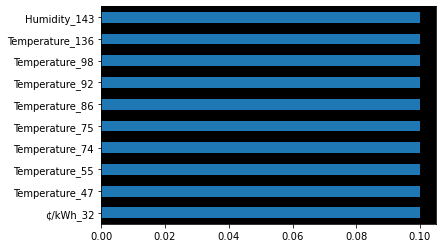

In [994]:
feat_importances = pd.Series(rf.feature_importances_, index=df_lagged.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [1012]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
gridsearch = {'bootstrap': [True],
     'max_depth': [10, 250],
     'min_samples_leaf': [2, 5],
     'n_estimators': [100, 200]}
# print(gridsearch)
# {'bootstrap': [True],
#  'max_depth': [10, 50, 250,1000],
#  'max_features': [2, 'sqrt'],
#  'min_samples_leaf': [1, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 1000, 2000]}

In [1013]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch = GridSearchCV(
 estimator = rf, 
 param_grid = gridsearch, 
 cv = 4,
 verbose=2, 
 n_jobs = 1)

In [1014]:
rf_GridSearch.fit(x_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100, total= 4.3min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100, total= 4.4min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100, total= 4.3min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100, total= 4.3min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200, total= 9.6min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200, total=10.0min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200, total= 9.7min
[CV] bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 331.2min finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 250],
                         'min_samples_leaf': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [1015]:
print(rf_GridSearch.best_score_)
print(rf_GridSearch.best_params_)

0.16804672756974906
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}


In [1016]:
rf = RandomForestRegressor(bootstrap= True,n_estimators=100,min_samples_leaf= 5,max_features=2
    ,criterion='mae',
    max_depth=10)

In [1018]:
rf.fit(x_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=10, max_features=2,
                      min_samples_leaf=5)

In [1019]:
prediction1 = rf.predict(x_test)

In [1020]:
prediction1

array([13.48188333, 14.24653333, 13.79440833, ..., 12.28345833,
       12.00640833, 13.02938333])

In [1021]:
prediction = pd.DataFrame(data=prediction1,columns=['prediction'])
prediction.to_csv('randomforestprediction.csv')
prediction

,prediction
0,13.481883
1,14.246533
2,13.794408
3,13.644700
4,13.209292
...,...
9283,13.354150
9284,12.385833
9285,12.283458
9286,12.006408


In [1022]:
len(prediction)

9288

In [1023]:
len(x_test)

9288

In [1024]:
x_test.isna().sum()

¢/kWh_24           0
Temperature_24     0
Humidity_24        0
¢/kWh_25           0
Temperature_25     0
                  ..
Temperature_167    0
Humidity_167       0
¢/kWh_168          0
Temperature_168    0
Humidity_168       0
Length: 435, dtype: int64

In [1025]:
y_test

,¢/kWh,predictions,difference,% error
Date,,,,
2019-12-01 01:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 02:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 03:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 04:00:00,10.791667,11.166167,0.374500,3.470270
2019-12-01 05:00:00,10.791667,11.166167,0.374500,3.470270
...,...,...,...,...
2020-12-31 19:00:00,36.850000,10.807333,26.042667,70.672094
2020-12-31 20:00:00,19.690000,10.807333,8.882667,45.112578
2020-12-31 21:00:00,20.780000,11.166167,9.613833,46.264838


In [1026]:
prediction['actual']=y_test['¢/kWh'].values
prediction.head(20)

,prediction,actual
0,13.481883,10.791667
1,14.246533,10.791667
2,13.794408,10.791667
3,13.644700,10.791667
4,13.209292,10.791667
5,13.428717,10.791667
6,13.580417,10.791667
7,14.144533,8.570000
8,13.896350,36.030000
9,13.738167,26.110000


In [1027]:
prediction['difference'] = np.abs(prediction['actual'] - prediction['prediction'])
prediction['% error'] = ((prediction['difference'] + 0.5) /(prediction['actual'] + 0.5))*100

In [1028]:
prediction['% error'].mean()

61.06766261180231

In [1029]:
mape = 100 * (prediction['difference'] / prediction['actual'])
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
100 - accuracy

64.3160086113409

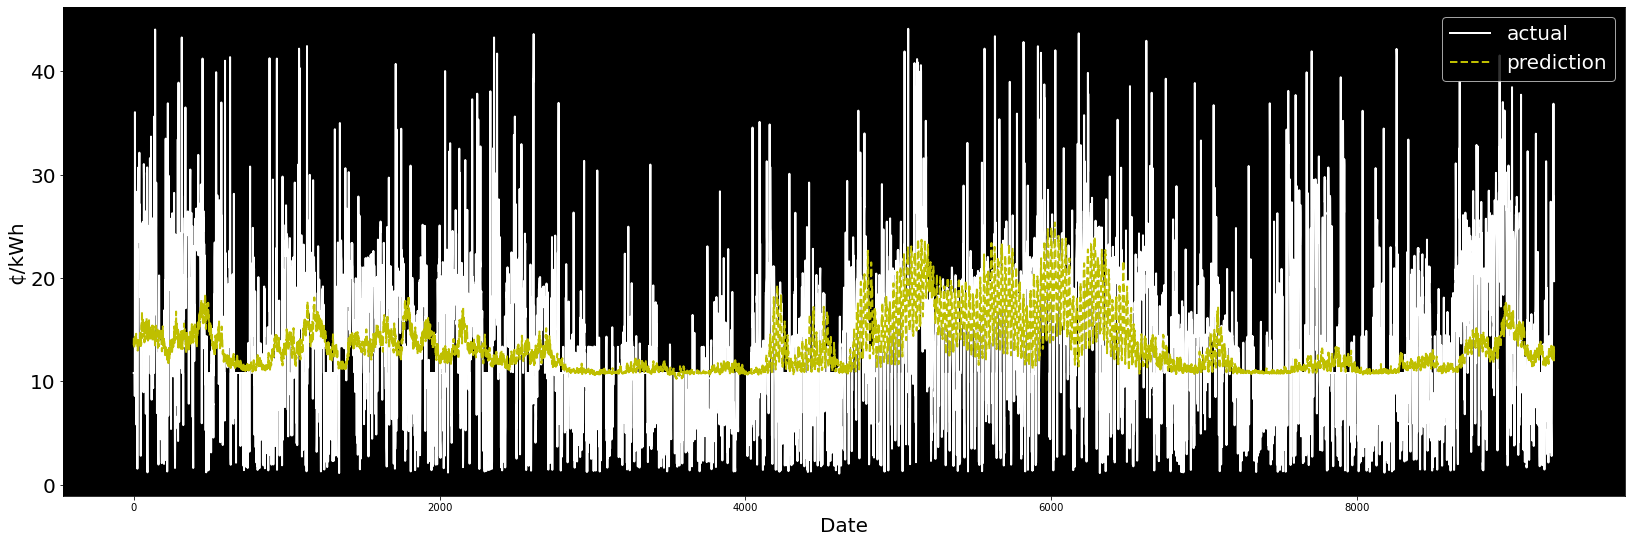

In [1030]:
fig, ax2 = plt.subplots(figsize = (28,9))

ax2.set_xlabel('Date', fontsize=20)
ax2.set_ylabel('¢/kWh', fontsize=20)
plt.rcParams['axes.facecolor'] = 'black'
ax2.plot(prediction['actual'], label = 'actual', color = 'w', linewidth=2)
ax2.plot(prediction['prediction'], label = 'prediction', color = 'y', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelsize = 20)

ax2.legend(prop={'size': 20},labelcolor='white')